<a href="https://colab.research.google.com/github/WhiteHum/Application-security/blob/main/2_03_Applying_Statistics_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying Statistics

## Overview

This lab will continue to build foundational understandings of descriptive statistics, focusing on the various approaches toward measuring deviation.  Much of this lab will focus on the ability to identify encrypted data based solely on descriptive statistics.

## Goals

By the end of this lab, you should be able to:

 * Explain the differences between variance, standard deviation, and median absolute deviation
 * Write code that will produce the variance for a dataset
 * Write code that will produce the standard deviation for a dataset
 * Write code that will produce the median absolute deviation for a dataset
 * Write code that can evaluate the likelihood that a specific set of data represents encrypted information
 
## Estimated Time: 30 - 45 minutes




# <img src="../images/task.png" width=20 height=20> Task 3.1

Please use the next cell to import both the Pandas and Numpy libraries.  Import Numpy as np and Pandas as pd.

In [ ]:
import numpy as np
import pandas as pd

In this lab we will work with a set of files of varying types.  All of the files that we will use are located in `../data/files` and each file type is in its own directory.  Let's begin by creating a dictionary that maps file types to the names of the files that are available.

# <img src="../images/task.png" width=20 height=20> Task 3.2

Using the `os` library, retrieve a list of all of the directory names in the `../data/files` directory.  Store these in a list that represents the types of files that we will be working with.

In [ ]:
import os as os
file_types = os.listdir('../data/files/')
file_types

['Archives',
 'JPEG Files',
 'SVG Files',
 'Text files',
 'UNIX Binaries',
 'Windows binaries',
 'Word docs']

Now that we have the file types, we are ready to obtain a list of the filenames for each type of file.

# <img src="../images/task.png" width=20 height=20> Task 3.3

Enumerate the files in each of the directories, assigning the list of files to a dictionary where the key is the file type.

In [ ]:
files = {}
for filetype in file_types:
    files[filetype] = os.listdir(f'../data/files/{filetype}/')

files

{'Archives': ['Archive 2.zip',
  'Archive 3.zip',
  'Archive 4.zip',
  'Archive.zip'],
 'JPEG Files': ['IMG_4128.JPG',
  'IMG_4129.JPG',
  'IMG_4132.JPG',
  'IMG_4133.JPG',
  'IMG_4134.JPG',
  'IMG_4135.JPG',
  'IMG_4136.JPG'],
 'SVG Files': ['SVG 1.svg',
  'SVG 10.svg',
  'SVG 2.svg',
  'SVG 3.svg',
  'SVG 4.svg',
  'SVG 5.svg',
  'SVG 6.svg',
  'SVG 7.svg',
  'SVG 8.svg',
  'SVG 9.svg'],
 'Text files': ['First.txt', 'Fourth.txt', 'Second.txt', 'Third.txt'],
 'UNIX Binaries': ['bash',
  'cat',
  'chmod',
  'cp',
  'csh',
  'dash',
  'date',
  'dd',
  'df',
  'echo'],
 'Windows binaries': ['dd.exe', 'WinSCP.exe'],
 'Word docs': ['Doc 1.doc',
  'Doc 2.doc',
  'Doc 3.doc',
  'Doc 4.doc',
  'Doc 5.doc']}

Let's pause and talk about where we are heading.  We are wondering, or theorizing, that the statistical behavior of the bytes in different types of files might be a useful tool for predicting what that file content is.  Our very specific plan is to use statistics to identify encrypted data, but if we can identify other file types, that's an added bonus.

Why is this useful and how could it be used?  While we are applying this task to examining files, we can use the technique in different ways.  If we stick with the idea of files, might it be interesting to identify encrypted attachments in email messages?  If we generalize away from files, could it be useful to find encrypted data streams on unusual ports?  Or, alternatively, to find streams that are *not* encrypted?  These are just a few ways that we might use the techniques discussed here.

# <img src="../images/task.png" width=20 height=20> Task 3.4

Since we are dealing with arbitrary data, it is reasonable to assume that at least some, if not most, of that data is binary.  Python provides the *binascii* library, which has some very useful helper functions for examining binary data.

Import the `binascii` library.  When that is done, read the first 32 bytes of every file and use the `hexlify()` covenience method from `binascii` to print these file headers out.

In [ ]:
import binascii
for filetype in files:
    for filename in files[filetype]:
        with open(f'../data/files/{filetype}/{filename}', 'rb') as f:
            chunk = f.read(32)
            print(f'{binascii.hexlify(chunk)}  --  {filename}')
        

b'504b0304140008000800e05c574e00000000000000007b220000210020006963'  --  Archive 2.zip
b'504b0304140008000800ab80154f0000000000000000f75d2b000c002000494d'  --  Archive 3.zip
b'504b0304140008000800538d634e0000000000000000a50600001a0020006e6f'  --  Archive 4.zip
b'504b0304140008000800259a254e0000000000000000001204000e0020003039'  --  Archive.zip
b'ffd8ffe15ecc45786966000049492a00080000000c000f010200060000009e00'  --  IMG_4128.JPG
b'ffd8ffe164f045786966000049492a00080000000c000f010200060000009e00'  --  IMG_4129.JPG
b'ffd8ffe1681c45786966000049492a00080000000c000f010200060000009e00'  --  IMG_4132.JPG
b'ffd8ffe15f5445786966000049492a00080000000c000f010200060000009e00'  --  IMG_4133.JPG
b'ffd8ffe1622445786966000049492a00080000000c000f010200060000009e00'  --  IMG_4134.JPG
b'ffd8ffe1649c45786966000049492a00080000000c000f010200060000009e00'  --  IMG_4135.JPG
b'ffd8ffe16a2445786966000049492a00080000000c000f010200060000009e00'  --  IMG_4136.JPG
b'3c3f786d6c2076657273696f6e3d22312e3022203f3e3c2144

No doubt when you look at these examples you can see obvious patterns.  If you weren't already aware of it, nearly all file types, especially binary file types, have some kind of *file header.*  As this name implies, it is found at the head, or beginning, of the file.  It contains various data structures that are specific to the file type in question.  For example, if we are looking at an image file, perhaps it contains a version number for the image file format, a bit depth, the overall dimensions of the image, compression information if the image is compressed, etc.

While file header information can be used to determine file type, it might be interesting to be able to take a random sample of a hunk of a file or packet stream and make a good guess as to what type of data it is *without* seeing the header.  This can allow us to sample parts of data streams and categorize them or to identify files that have unexpected data within them that doesn't fit the normal behavior for the file type based on the header.

## Histograms

When we return to the lecture portion of the course, we will begin by discussing the notion of a histogram in some depth.  A histogram is typically rendered as a bar chart that seeks to visualize how our values cluster.  Imagine we had random values between zero and one hundred.  How frequently does each random number occur?  A histogram is the type of diagram used to visualize the answer to this question.

While we can create a histogram showing the frequency with which every value occurs, more typically the values are grouped together into "bins," which are ranges of values.  For example, the values between zero and nine, ten and nineteen, twenty and twentynine, etc.

### Important Note!

When plotting a histogram, we must defined the number of bins.  With this in mind, we need to be mindful of how the bins are formed.  If we define the number of bins (using an integer), then the bins will all be equal-width.  If we define the bins as a range of values, however, the right-most bin (highest value in the range) may not behave as you expect.

For example, if we were to use the `bins` keyword argument to specify a range of bins such as `range(0,4)`, the bins will effectively use the list of values `[0, 1, 2, 3]`.  This means that the first bin will contain all values from $[0,1)$, where the square bracket indicates that the range is inclusive and the parenthesis indicates that it is exclusive.  Continuing from this point, the bins would have the ranges $[1, 2), [2, 3]$.  Notice the difference in the final bin.  The value three does not appear in its own bin!  Instead, it is grouped with the bin to the left!

Imagine that you wanted to generated a histogram visualizing the frequency with which each byte value appears in a file.  You could do this using `bins=256` to force 256 bins to be generated.  However, you may discover that the automatically generated bins do not quite break on byte boundaries!  As a result, you might want to force it to use `bins=range(0,257)`.  Notice that we use `257` rather than `256`.  This causes the final bin to be $[255, 256]$.  If we were to use `range(0,256)`, our final bin would be $[254, 255]$, which would include 254 and 255 bytes in the same bin, which is not what we want.

You may want to bear this in mind when plotting histograms below.

# <img src="../images/task.png" width=20 height=20> Task 3.5

Let's visualize our files.  Create a function that takes a filename as an argument and produces a histogram of the bytes within that file.  Verify that the function works by passing in a file from our sample data.

When generating a histogram, the default is to generate a histogram with only 10 bins.  We would like to see the frequency of bytes granularly, so set the `bins` keyword argument to be equal to the range of values from 0 to 255.

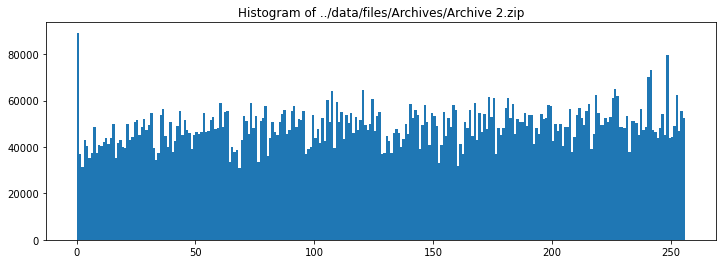

In [ ]:
import matplotlib.pyplot as plt

def plot_file(filename):
    with open(filename, 'rb') as f:
        data = bytearray(f.read())
    plt.figure(figsize=(12,4))
    plt.hist(data, bins=range(0,257))
    plt.title(f'Histogram of {filename}')
    plt.show()

plot_file(f'../data/files/{file_types[0]}/{files[file_types[0]][0]}')

Let's generalize this a bit so that we can plot all of our files in one large plot.

# <img src="../images/task.png" width=20 height=20> Task 3.6

Rewrite your plotting function so that it can accept an axes value to use for the plot.  When you have it working, plot all of the files in a grid that is five plots wide and as high as needed.

42 subplots required
Creating 9x5 grid


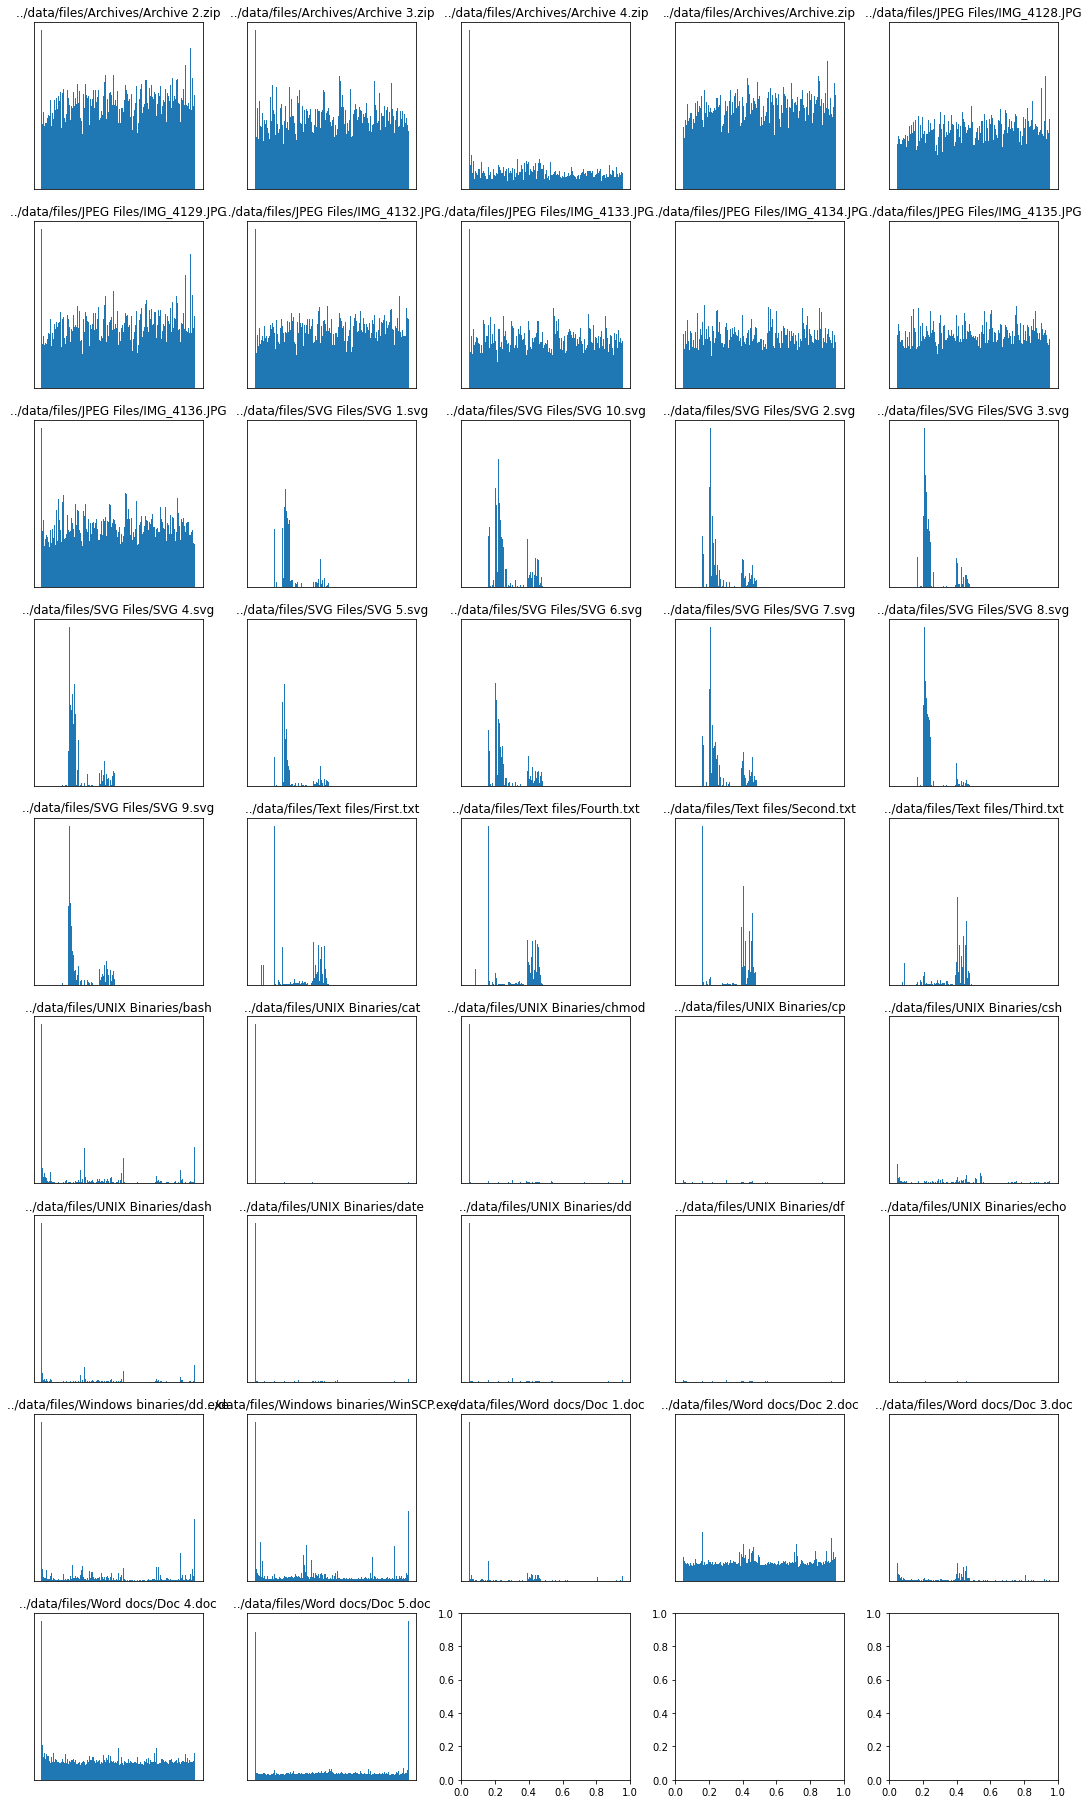

In [ ]:
def plot_file(filename, axes=plt):
    with open(filename, 'rb') as f:
        data = bytearray(f.read())
    axes.hist(data, bins=range(0,257))
    axes.set_title(filename)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    
plt.rcParams["figure.figsize"] = (15, 25) # (w, h)

total_subplots = 0
for filetype in files:
    total_subplots += len(files[filetype])

print(f'{total_subplots} subplots required')
columns = 5
rows = int((total_subplots / columns) + 1)
print(f'Creating {rows}x{columns} grid')
figure, axes = plt.subplots(rows, columns)
figure.tight_layout()
plot_number = 0
for filetype in files:
    for filename in files[filetype]:
        plot_file(f'../data/files/{filetype}/{filename}', axes=axes[int(plot_number / columns), (plot_number % columns)] )
        plot_number += 1

plt.show()

Visualizations are great... As humans, they really resonate with us.  Let's look at the data from a more mathematical perspective.

# <img src="../images/task.png" width=20 height=20> Task 3.7

Calculate and print the mean and the standard deviation for each file.  Then generate the mean and standard deviation for each file *type.*  Print these values and the comparison.

In [ ]:
def get_file_stats(filename):
    with open(filename, 'rb') as f:
        file_bytes = bytearray(f.read())
    data = np.frombuffer(file_bytes, np.uint8)
    return(np.mean(data), np.std(data))


filetype_mean = {}
filetype_std = {}
for filetype in files:
    print(filetype)
    for filename in files[filetype]:
        (mean,std) = get_file_stats(f'../data/files/{filetype}/{filename}')
        print(f'\t{filename}:\t{mean}\t{std}')
        filetype_mean[filetype] = np.append(filetype_mean[filetype], np.array(mean)) if filetype in filetype_mean.keys() else np.array(mean)
        filetype_std[filetype] = np.append(filetype_std[filetype], np.array(std)) if filetype in filetype_std.keys() else np.array(std)

print(f'Filetype\tMean\tStandard Deviation')
for filetype in files:
    print(f'{filetype}\t{filetype_mean[filetype].mean()}\t{filetype_std[filetype].mean()}')

Archives
	Archive 2.zip:	130.91492549606775	73.66183170671034
	Archive 3.zip:	127.60347840180562	73.48350883144164
	Archive 4.zip:	119.16954757252367	75.82767883926647
	Archive.zip:	130.80703596690176	73.62082396617552
JPEG Files
	IMG_4128.JPG:	130.81544721877486	73.8796428820107
	IMG_4129.JPG:	131.79432395949533	73.99797556877964
	IMG_4132.JPG:	130.85781242014036	73.99060747247252
	IMG_4133.JPG:	126.14240194672747	73.70649871804544
	IMG_4134.JPG:	126.58287331173675	73.73456358687031
	IMG_4135.JPG:	127.81080246050026	73.94733292647251
	IMG_4136.JPG:	127.54657419592903	73.47391431031421
SVG Files
	SVG 1.svg:	55.745779993202675	19.16017856233266
	SVG 10.svg:	63.063985374771484	26.169883765356904
	SVG 2.svg:	62.40623162845385	26.52843686202762
	SVG 3.svg:	58.62232905982906	22.67938918314996
	SVG 4.svg:	61.095327102803736	24.551160398026102
	SVG 5.svg:	56.826486817903124	21.95515321675025
	SVG 6.svg:	62.70463078848561	26.767910216419516
	SVG 7.svg:	63.59497021839841	27.074597560688435
	SVG

More than anything else that we have done, ths last task should make you very conscious of the fact that plotting the data in a visualization is *very slow* compared to the raw processing of the data!  Still, we as humans like pictures, so we will continue to plot a number of things throughout the course.

Another "Aha!" moment should have happened when you look at the standard deviations and the averages.  For example, compare the file by file and the overall means and standard deviations for the JPEG and Zip files.  They are suspiciously similar!  Would it surprise you to discover that, while JPEG doesn't use Zip, JPEG produces a compressed image?

The Windows and UNIX binaries are also interesting!  Here, the fact that they are so different is what is interesting.  Given additional research using many more sample binaries, could it turn out that we can trivially distinguish one from the other using the mean and the standard deviation?

We'd like to get back to our primary hypothesis, however.  We were most interested in how unencrypted files differ from encrypted files.  Let's find out!

To do so, we need a utility function that can encrypt our data for us.  Encrypting the data turns out to be pretty simple:

```
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

key = os.urandom(32)
iv = os.urandom(16)
aes_cipher = Cipher(algorithms.AES(key), modes.GCM(iv))
encryptor = aes_cipher.encryptor()
ciphertext = encryptor.update(file_bytes) + encryptor.finalize()
```

# <img src="../images/task.png" width=20 height=20> Task 3.8

Using the above code as a template, build a second function that will read a file, encrypt the data, and then produce the mean and standard deviation of the resulting bytes as a returned tuple.

In [ ]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

def encrypt_and_stats(filename):
    with open(filename, 'rb') as f:
        file_bytes = bytearray(f.read())
    key = os.urandom(32)
    iv =os.urandom(16)
    aes_cipher = Cipher(algorithms.AES(key), modes.GCM(iv))
    encryptor = aes_cipher.encryptor()
    ciphertext = encryptor.update(file_bytes) + encryptor.finalize()
    data = np.frombuffer(ciphertext, np.uint8)
    return(np.mean(data), np.std(data))

encrypt_and_stats('../data/files/Archives/Archive.zip')

(127.4757824069759, 73.92717802742733)

Now that we have that working, let's compute and print all of the means and standard deviations for all of the files and then the filetypes.

# <img src="../images/task.png" width=20 height=20> Task 3.9

Print a table that shows each filename, encrypted mean, and encrypted standard deviation.  Following this, print a table showing the average encrypted mean and the average encrypted standard deviation.

In [ ]:
filetype_mean = {}
filetype_std = {}
for filetype in files:
    print(filetype)
    for filename in files[filetype]:
        (mean,std) = encrypt_and_stats(f'../data/files/{filetype}/{filename}')
        print(f'\t{filename}:\t{mean}\t{std}')
        filetype_mean[filetype] = np.append(filetype_mean[filetype], np.array(mean)) if filetype in filetype_mean.keys() else np.array(mean)
        filetype_std[filetype] = np.append(filetype_std[filetype], np.array(std)) if filetype in filetype_std.keys() else np.array(std)

print(f'Filetype\tMean\tStandard Deviation')
for filetype in files:
    print(f'{filetype}\t{filetype_mean[filetype].mean()}\t{filetype_std[filetype].mean()}')

Archives
	Archive 2.zip:	127.53326591247874	73.8840065142557
	Archive 3.zip:	127.5328556326745	73.86531264072832
	Archive 4.zip:	127.2074252217045	74.07209628224912
	Archive.zip:	127.4618104099999	73.86564252120259
JPEG Files
	IMG_4128.JPG:	127.50813279122609	73.89638852195435
	IMG_4129.JPG:	127.46565619634119	73.91971905547028
	IMG_4132.JPG:	127.52891615583354	73.93213798033213
	IMG_4133.JPG:	127.50528710606196	73.88413230223915
	IMG_4134.JPG:	127.5204222511814	73.89142573957375
	IMG_4135.JPG:	127.41350804639303	73.89550441979192
	IMG_4136.JPG:	127.54801997532056	73.90147018407993
SVG Files
	SVG 1.svg:	128.3104112382463	74.10354198837122
	SVG 10.svg:	126.80329067641682	74.25560423733856
	SVG 2.svg:	127.94473838918283	74.5246539600101
	SVG 3.svg:	127.19791666666667	72.85592038090392
	SVG 4.svg:	127.29753610875106	73.94929491366571
	SVG 5.svg:	126.5009196811772	74.34819463679912
	SVG 6.svg:	127.33166458072591	72.91592625403925
	SVG 7.svg:	130.17736598279285	74.15832806494201
	SVG 8.svg:

The output is *very* interesting!  Notice that the average for every filetype is nearly identical, as is the standard deviation.  Think about this for just a moment.  *This is exactly what we would expect.*  If encrypting different data results in differing statistics, it would provide a way to reveal information about the original data without the key.

This said, there *is* something a little bit odd.  

# <img src="../images/task.png" width=20 height=20> Task 3.10

Please plot a histogram of the encrypted bytes from a single file.

In [ ]:
def encrypt_plot_and_stats(filename):
    with open(filename, 'rb') as f:
        file_bytes = bytearray(f.read())
    key = os.urandom(32)
    iv =os.urandom(16)
    aes_cipher = Cipher(algorithms.AES(key), modes.GCM(iv))
    encryptor = aes_cipher.encryptor()
    ciphertext = encryptor.update(file_bytes) + encryptor.finalize()
    data = np.frombuffer(ciphertext, np.uint8)
    plt.figure(figsize=(10,5))
    plt.hist(data, bins=range(0,257))
    plt.show()
    return(np.mean(data), np.std(data))

encrypt_plot_and_stats('../data/files/Archives/Archive 2.zip')

Now *that's* interesting!  It turns out that the AES algorithm does produce a pretty flat histogram, but there are nearly two times the average bytes that contain 255.  It is crystal clear that there is very little variance in the frequency with which each value appears.

That last statement should give you pause.  We just said that it seems that there is *very little* variance in the frequency of each byte.  However, the standard deviation, effectively the square root of the variance, is 73.89.  That doesn't seem *minimal.*  What's happening?

The standard deviation what we have calculated so far is for *the data overall.*  A more interesting statistic might be described using the words in the paragraphs just above; the standard deviation of the *frequency with which each value appears.*  In other words, rather than asking, "What is the standard deviation of the byte values?" which is what we have calculated so far, we are instead standing back further asking about the frequency with which each appears.

# <img src="../images/task.png" width=20 height=20> Task 3.11

Write some Python code to determine the frequency with which each byte appears in our encrypted data.  Then generate the standard deviation of *this* data and think about it.  

In [ ]:
def encrypt_plot_and_stats(filename):
    with open(filename, 'rb') as f:
        file_bytes = bytearray(f.read())
    key = os.urandom(32)
    iv =os.urandom(16)
    aes_cipher = Cipher(algorithms.AES(key), modes.GCM(iv))
    encryptor = aes_cipher.encryptor()
    ciphertext = encryptor.update(file_bytes) + encryptor.finalize()
    data = np.frombuffer(ciphertext, np.uint8)
    byte_frequencies = []
    for i in range(0,256):
        byte_frequencies.append(len(data[np.where(data == i)]))
    byte_frequencies = np.array(byte_frequencies)
    print(byte_frequencies.mean(),byte_frequencies.std())
    plt.figure(figsize=(10,5))
    plt.hist(data, bins=range(0,257))
    plt.show()
    print(byte_frequencies.min(), byte_frequencies.max())
    return(np.mean(data), np.std(byte_frequencies))

encrypt_plot_and_stats('../data/files/Archives/Archive 2.zip')

Let's attach one more metric to this.  228 or 229 can *seem* like a very large measure of variation.  What if we consider it as a percentage of the average?  If we encrypt the *Archive 2.zip* file we find that this seemingly large deviation is less than 0.5%!

# Conclusion

So what can we take away from this exercise?  First, we have definitely proven our hypothesis.  That is, we can *absolutely* identify encrypted data by examining the overall variance of the data relative to the frequency with which any given byte appears in the data.  We also had the opportunity to manipulate the data in a variety of ways, realizing that the straightforward average and standard deviation applied to the data itself was not nearly as interesting as the 2nd or 3rd order application of these functions.

What we've learned:

* How to manipulate Numpy arrays effectively to filter data
* How the theorize, experiment, and evaluate data during the data exploration phase
* A better understanding of what variance and standard deviation mean and what they can be used for